<a href="https://colab.research.google.com/github/rupeshthapa123/NotebookProject/blob/main/Lab10_RupeshThapa_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#General Adversarial Network (GAN)

It was introduced in 2014 by Ian Goodfellow and it is an alternative to VAE.Generate realistic synthetic images

• Generator. Creates images

• Discriminator. Predicts if an image comes from the training set

• Train both at the same time

• Image from generator is fed to discriminator MANY times, if the
image is caught to be from generator, try again.

• Finally, the generator learns the latent image space and creates
images statistically identical to dataset

• Latent image spaces less structured than VAEs (i.e., no vector of
meaningful variations)

• Creates discrete points in latent space

• For training, no real minimum is ever set or reached

• Every step, there is a change in both generator and discriminator

• Look for an equilibrium between the two networks



## We are making a directory for celeb dataset and downloading the celeba gan dataset

In [ ]:
 !mkdir celeba_gan

In [ ]:
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=ae03bd6f-a130-41ef-93e3-0b175909d116
To: /content/celeba_gan/data.zip
100% 1.44G/1.44G [00:34<00:00, 41.2MB/s]


In [ ]:
!unzip -qq celeba_gan/data.zip -d celeba_gan

## Loading the dataset from directory

In [ ]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    # smart_resize=True
)

Found 202599 files.


## Rescaling the dataset inside [0-1] range

In [ ]:
dataset = dataset.map(lambda x: x / 255)

## Displaying one sample

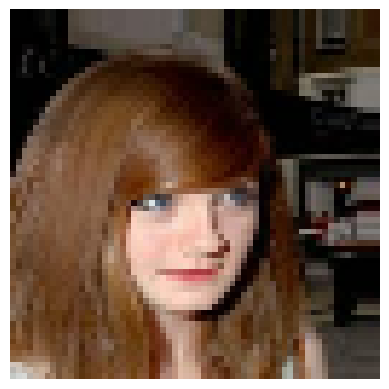

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
  plt.axis("off")
  plt.imshow((x.numpy() * 255).astype("int32")[6])
  break

## GAN Implementation creating a discriminator

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## creating a generator

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

## Creating a GAN model

In [ ]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN,self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## Creating a GAN monitor class

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

## Compiling and training a GAN

In [ ]:
epochs = 2

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/2
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1652s 258ms/step - d_loss: 0.5770 - g_loss: 1.2823
Epoch 2/2
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1626s 257ms/step - d_loss: 0.6506 - g_loss: 1.0822


## Displaying the image generated by GAN

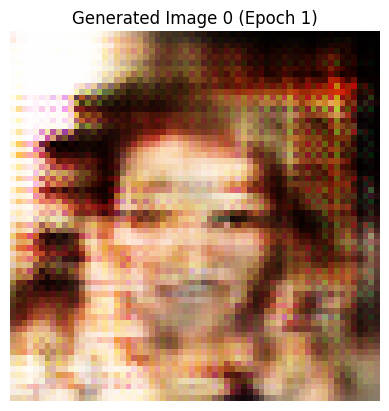

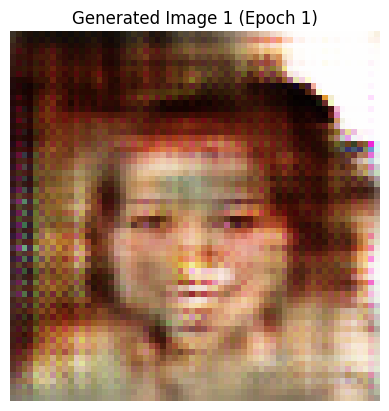

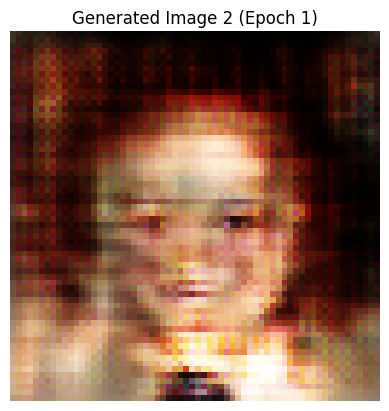

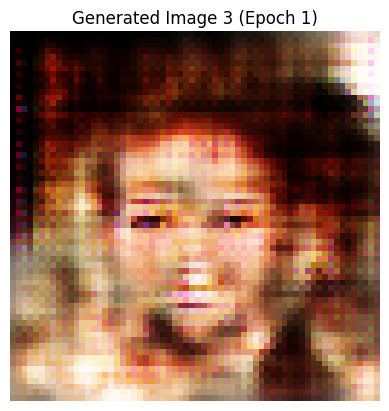

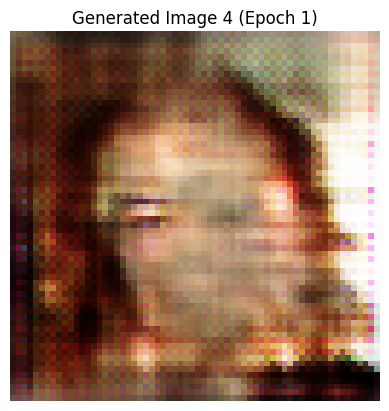

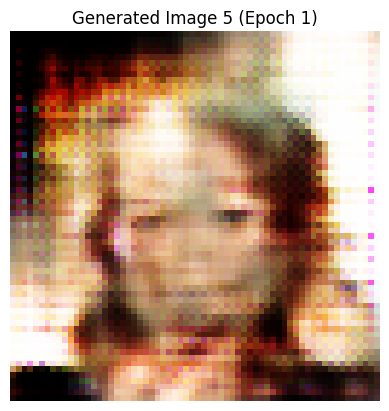

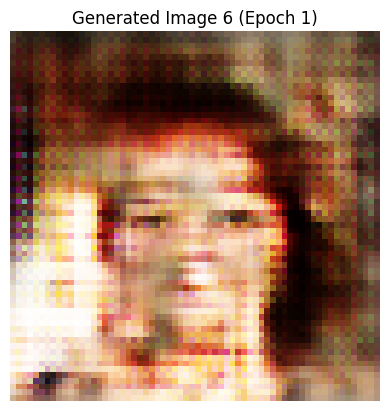

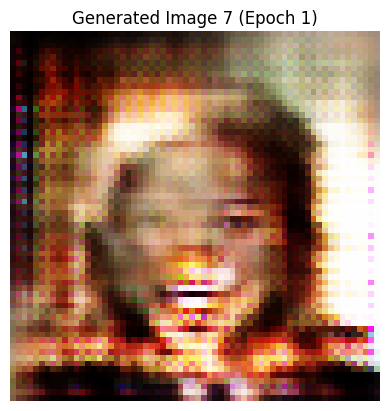

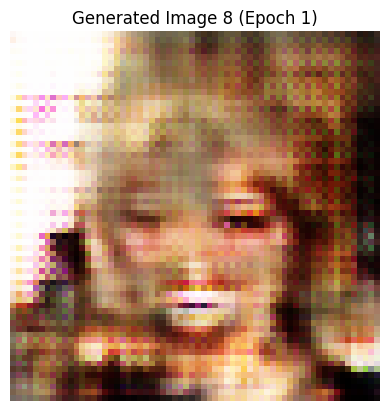

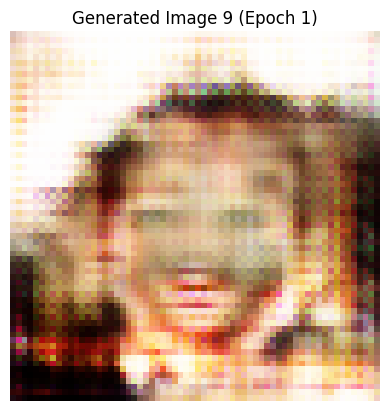

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define the number of images and epoch
num_img = 10  # Replace with the actual number of images you have
epoch = 1  # Replace with the current epoch number

# Loop through the images and display them using matplotlib
for i in range(num_img):
    img_path = f"/content/generated_img_{epoch:03d}_{i}.png"
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(f"Generated Image {i} (Epoch {epoch})")
        plt.axis('off')
        plt.show()
    else:
        print(f"Image {img_path} not found.")

## Conclusion

Although for proper results for the model we have to run the epochs for 100 times but since we have limited resources of GPU or TPU only 2 epochs has been used and we got the result. As per the models previous response the GAN model would start giving good results from 20 epochs.